In [ ]:
%%capture
!pip install transformers
!pip install datasets

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from imblearn import under_sampling
from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset = load_dataset("tweets_hate_speech_detection")

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (/root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset['train']

Dataset({
    features: ['label', 'tweet'],
    num_rows: 31962
})

In [ ]:
df_1 = pd.DataFrame(columns = ['class','tweet'])
df_1['tweet'] = dataset['train']['tweet']
df_1['class'] = dataset['train']['label']

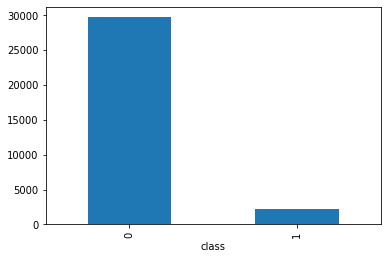

In [ ]:
df_1.groupby(['class']).size().plot.bar()

In [ ]:
#undersampler = under_sampling.RandomUnderSampler(sampling_strategy = 'all', random_state = 42)
#tweets, classes = undersampler.fit_resample(np.array(df_1['tweet']).reshape(-1,1), df_1['class'])
#tweets, classes = undersampler.fit_resample(tweets, classes)

In [ ]:
#df = pd.DataFrame(columns = ['tweet','class'])
#df['tweet'] = pd.DataFrame(tweets)
#df['class'] = pd.DataFrame(classes)

In [ ]:
#df.groupby(['class']).size().plot.bar()

In [ ]:
df = df_1.copy(deep=True)

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {0:0,
          1:1}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['class']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 50, truncation=True,
                                return_tensors="pt") for text in df['tweet']]
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        #dropout_output = self.dropout(pooled_output)
        #linear_output = self.linear(dropout_output)
        relu_1=self.relu(pooled_output)
        relu_2=self.relu(relu_1)
        final_layer1 = self.linear(relu_2)
        final_layer = self.softmax(final_layer1)


        return final_layer

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs,batch):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    return total_acc_test / len(test_data)

from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(model, test_data):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
    preds = []
    y_true = []

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
    
        for test_input, test_label in test_dataloader:
              
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              y_true.append(test_label.cpu().numpy())
              preds.append(model(input_id, mask).cpu().detach().numpy()[0][1])
              #print(y_true,preds)
      
    preds = np.array(preds).astype(float)
    y_true = np.array(y_true).astype(float)
    #print(preds,y_true)
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return roc_auc

In [ ]:
np.random.seed(112)
#df = df.sample(n=4000)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

25569 3196 3197


In [ ]:
#EPOCHS = [1,2]
#BATCHES = [16,32]
#LR_LIST = [1e-12,1e-9]
#results = pd.DataFrame(columns = ['Epochs','Batch_size','LR','Test_accuracy'])
#
#for epoch in EPOCHS:
#  for batch in BATCHES:
#    for lr in LR_LIST:
#      model = BertClassifier()
#      train(model, df_train, df_val, lr, epoch,batch)
#      acc = evaluate_roc(model,df_test)
#      results = results.append({'Epochs':epoch,'Batch_size':batch,'Test_accuracy': acc,'LR':lr}, ignore_index=True)

Test accuracy for non-balanced data

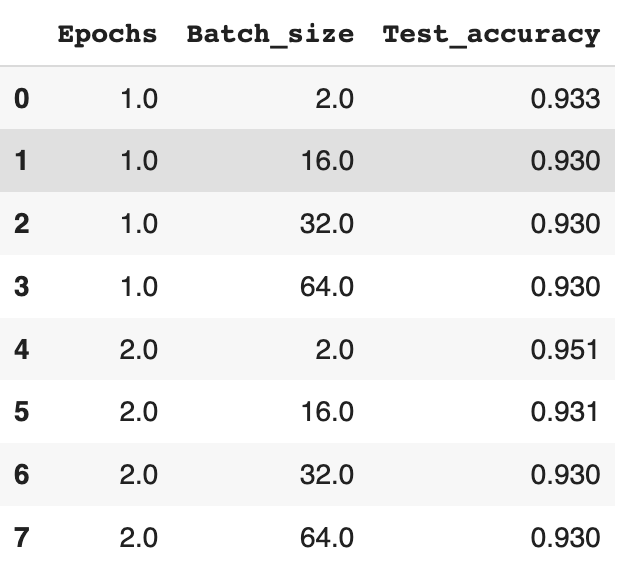

In [ ]:
model = BertClassifier()
LR = 1e-6
train(model, df_train, df_val, LR, epochs=1,batch=64)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 400/400 [06:17<00:00,  1.06it/s]


Epochs: 1 | Train Loss:  0.007 | Train Accuracy:  0.930 | Val Loss:  0.006 | Val Accuracy:  0.926


In [ ]:
evaluate(model, df_test)

0.9299343134188301

[0.04090217 0.04084    0.04495585 ... 0.0502535  0.04219576 0.0519427 ] [[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
AUC: 0.5894
Accuracy: 92.99%


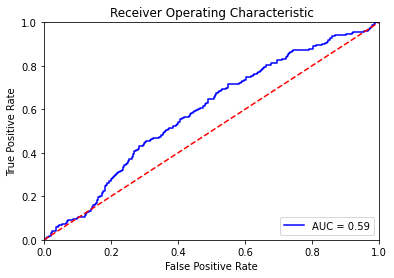

0.5893803156984287

In [ ]:
evaluate_roc(model,df_test)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_ukraine = pd.read_csv('/content/drive/MyDrive/tweets_ukraine.csv')
df_ukraine.drop(columns=['Unnamed: 0'], axis=1, inplace =True)
df_ukraine.rename(columns={"0":'tweet'},inplace=True)
df_ukraine['class'] = np.zeros(1000)

In [ ]:
data = Dataset(df_ukraine)
data_dataloader = torch.utils.data.DataLoader(data, batch_size=1)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
predictions = pd.DataFrame(columns=['tweet','pred-0','pred-1'])
i=0
for test_input, test_label in data_dataloader:

      test_label = test_label.to(device)
      mask = test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)
      predictions = predictions.append({'tweet':df_ukraine.iloc[i,0], 'pred-0':output.cpu().detach().numpy()[0][0],'pred-1':output.cpu().detach().numpy()[0][1]},ignore_index=True)
      i+=1

In [ ]:
print(predictions.iloc[10,0],
predictions.iloc[10,1],
predictions.iloc[10,2])

RT @kylegriffin1: British defense ministry: Russian forces have suffered thousands of casualties during their invasion of Ukraine and are l… 0.9509175 0.049082458


In [ ]:
print(predictions.iloc[496,0],
predictions.iloc[496,1],
predictions.iloc[496,2])

Please help support Ukraine, add a #Twibbon now! https://t.co/GC92W4T6Yi 0.94632244 0.053677555
